# Modeling Multiclass IDS (5 Classes) — v5 Memory Optimized

## Kesesuaian:
- ✅ Sesuai dengan `preprocessRevisi4-1.ipynb`
- ✅ Sesuai dengan proposal BAB 3
- ✅ Memory-optimized untuk mencegah kernel crash

## Fokus:
- DNN reguler (feedforward), LeakyReLU + Dropout
- Class weight, early stopping, gradient clipping
- Phase A: batch eksplorasi progresif
- Phase B: final training pada full data
- Simpan artefak lengkap sesuai spesifikasi proposal

In [1]:
import pandas as pd
import numpy as np
import json, joblib, gc
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn. preprocessing import RobustScaler, StandardScaler
from sklearn. feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

ART_DIR = Path("./artifacts_multiclass_collapsed_v4")
ART_DIR.mkdir(parents=True, exist_ok=True)

data_art = joblib.load(ART_DIR / 'lite_clean_data_collapsed.pkl')
full_df = data_art['full_df']
phaseA_df = data_art['phaseA_df']
label_map = data_art['label_map']
inv_label_map = data_art['inv_label_map']
LABEL_COL = data_art['label_col']
feature_cols = data_art['feature_cols']
num_classes = len(label_map)

print("Full data shape:", full_df.shape)
print("Phase A shape:", phaseA_df.shape)
print("Kelas:", num_classes)
print("Fitur final:", len(feature_cols))
clear_memory()

Full data shape: (2568389, 83)
Phase A shape: (571603, 83)
Kelas: 5
Fitur final: 58


## 1. Transform Pipeline (fit & apply — locked)
Sesuai dengan preprocessing: RobustScaler, skew_threshold=1.5

In [2]:
SKEW_THRESHOLD = 1.5
USE_ROBUST_SCALER = True

def transform_fit(X_train_df, X_test_df, skew_threshold=1.5, use_robust=True):
    X_train_df = X_train_df.apply(pd.to_numeric, errors='coerce'). copy()
    X_test_df  = X_test_df.apply(pd.to_numeric, errors='coerce'). copy()
    medians = {}
    for c in X_train_df.columns:
        if X_train_df[c].isna().any():
            med = float(X_train_df[c].median())
            medians[c] = med
            X_train_df[c] = X_train_df[c].fillna(med)
    for c in X_test_df.columns:
        if c in medians:
            X_test_df[c] = X_test_df[c].fillna(medians[c])

    vt = VarianceThreshold(0.0)
    X_train_v = vt.fit_transform(X_train_df)
    cols = [c for c,m in zip(X_train_df.columns, vt.get_support()) if m]
    X_test_v = X_test_df[cols].values

    df_tmp = pd.DataFrame(X_train_v, columns=cols)
    skewness = df_tmp.skew()
    heavy_cols = skewness[abs(skewness) > skew_threshold].index. tolist()
    del df_tmp
    
    for c in heavy_cols:
        idx = cols.index(c)
        X_train_v[:, idx] = np.log1p(np.clip(X_train_v[:, idx], 0, None))
        X_test_v[:, idx]  = np.log1p(np. clip(X_test_v[:, idx], 0, None))

    scaler = RobustScaler() if use_robust else StandardScaler()
    X_train_s = scaler.fit_transform(X_train_v). astype('float32')
    X_test_s  = scaler.transform(X_test_v).astype('float32')
    
    del X_train_v, X_test_v
    clear_memory()
    
    meta = {'cols': cols, 'heavy_cols': heavy_cols, 'scaler': scaler, 'medians': medians}
    return X_train_s, X_test_s, meta

def transform_apply(X_df, meta):
    cols = meta['cols']; heavy_cols = meta['heavy_cols']; scaler = meta['scaler']; medians = meta['medians']
    X_df = X_df[cols]. copy(). apply(pd.to_numeric, errors='coerce')
    for c in cols:
        if X_df[c]. isna().any():
            fill = medians. get(c, X_df[c]. median())
            X_df[c] = X_df[c].fillna(fill)
    for c in heavy_cols:
        if c in X_df.columns:
            X_df[c] = np.log1p(np.clip(X_df[c], 0, None))
    X_s = scaler.transform(X_df. values). astype('float32')
    return X_s

## 2.  Utilities: class weight, model, training, eval
Sesuai proposal: AdamW, weight_decay=1e-4, gradient clipping=5.0, early stopping patience=12

In [4]:
device = torch.device('cuda' if torch. cuda.is_available() else 'cpu')
print("Device:", device)

def to_array_features(X):
    if isinstance(X, pd. DataFrame):
        X = X.values
    return np.asarray(X, dtype=np.float32)

def to_array_labels(y):
    if isinstance(y, pd.Series):
        y = y.values
    y = np.asarray(y)
    if y.dtype != np.int64:
        y = y. astype(np. int64)
    return y

def compute_class_weight(y, num_classes):
    counts = Counter(y)
    total = sum(counts.values())
    w = {cls: total / (num_classes * cnt) for cls, cnt in counts.items()}
    return torch.tensor([w. get(i, 1.0) for i in range(num_classes)], dtype=torch.float32)

def build_dnn(input_dim, layer_sizes, num_classes, activation='leaky_relu', dropout=0.35):
    acts = {'relu': nn.ReLU(), 'leaky_relu': nn.LeakyReLU(0.01), 'tanh': nn. Tanh()}
    seq = []; prev = input_dim
    for h in layer_sizes:
        seq += [nn.Linear(prev, h), acts. get(activation, nn.LeakyReLU(0.01)), nn.Dropout(dropout)]
        prev = h
    seq. append(nn.Linear(prev, num_classes))
    return nn.Sequential(*seq)

def train_dnn(model, X_train, y_train, X_val, y_val, class_weight_tensor,
              lr=0.001, max_epochs=60, batch_size=128, patience=12):
    X_train = to_array_features(X_train); y_train = to_array_labels(y_train)
    X_val   = to_array_features(X_val);   y_val   = to_array_labels(y_val)
    
    ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
    
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss(weight=class_weight_tensor. to(device))
    
    best_loss = float('inf'); best_state = None; wait = 0
    val_batch_size = min(4096, len(X_val))
    
    for epoch in range(max_epochs):
        model. train()
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
        
        model.eval()
        val_losses = []
        with torch.no_grad():
            for i in range(0, len(X_val), val_batch_size):
                xv = torch.tensor(X_val[i:i+val_batch_size], dtype=torch.float32).to(device)
                yv = torch.tensor(y_val[i:i+val_batch_size], dtype=torch.long).to(device)
                v_logits = model(xv)
                v_loss = criterion(v_logits, yv). item()
                val_losses.append(v_loss * len(xv))
                del xv, yv, v_logits
        
        avg_val_loss = sum(val_losses) / len(X_val)
        
        if avg_val_loss < best_loss - 1e-4:
            best_loss = avg_val_loss
            best_state = {k: v. cpu(). clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break
    
    if best_state is not None:
        model. load_state_dict(best_state)
    
    clear_memory()
    return model

def batch_predict(model, X, batch_size=4096):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            xb = torch. tensor(X[i:i+batch_size], dtype=torch.float32).to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1). cpu().numpy()
            all_preds.append(preds)
            del xb, logits
    clear_memory()
    return np.concatenate(all_preds)

def macro_f1_eval(y_true, y_pred):
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return rep['macro avg']['f1-score'], rep

def run_experiment(X_train_df, y_train, X_test_df, y_test,
                   layers, activation, dropout, lr, epochs, batch_size,
                   meta=None, reuse_transform=False):
    if reuse_transform and meta is not None:
        X_train_t = transform_apply(X_train_df[feature_cols], meta)
        X_test_t  = transform_apply(X_test_df[feature_cols], meta)
    else:
        X_train_t, X_test_t, meta = transform_fit(X_train_df[feature_cols], X_test_df[feature_cols], 
                                                   skew_threshold=SKEW_THRESHOLD, use_robust=USE_ROBUST_SCALER)

    X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
        X_train_t, to_array_labels(y_train), test_size=0.2, stratify=y_train, random_state=RANDOM_STATE)

    class_w = compute_class_weight(y_tr_sub, num_classes)

    model = build_dnn(X_tr_sub. shape[1], layers, num_classes, activation=activation, dropout=dropout)
    model = train_dnn(model, X_tr_sub, y_tr_sub, X_val, y_val, class_w,
                      lr=lr, max_epochs=epochs, batch_size=batch_size, patience=12)

    y_pred = batch_predict(model, X_test_t, batch_size=4096)
    mf1, rep = macro_f1_eval(to_array_labels(y_test), y_pred)
    
    del X_tr_sub, X_val, y_tr_sub, y_val, X_train_t, X_test_t
    clear_memory()
    
    return mf1, rep, model, meta

Device: cpu


## 3. Phase A — Batch Eksplorasi Progresif
Sesuai proposal: eksplorasi split, layers, activation, epochs, lr, batch_size

In [7]:
phaseA_features = phaseA_df[feature_cols]
phaseA_labels   = phaseA_df['Label_encoded']

print("=" * 50)
print("Batch 1: Split Ratio")
print("=" * 50)

split_variants = [0.7, 0.8, 0.9]
baseline_layers = [256, 128, 128]
baseline_activation = 'relu'
baseline_lr = 0.001
baseline_epochs = 40
baseline_batch_size = 128

batch1 = []
for sr in split_variants:
    print(f"Testing split={sr}... ")
    X_tr, X_te, y_tr, y_te = train_test_split(phaseA_features, phaseA_labels, train_size=sr, stratify=phaseA_labels, random_state=RANDOM_STATE)
    mf1, rep, model, meta = run_experiment(X_tr, y_tr, X_te, y_te,
        layers=baseline_layers, activation=baseline_activation, dropout=0.35,
        lr=baseline_lr, epochs=baseline_epochs, batch_size=baseline_batch_size,
        meta=None, reuse_transform=False)
    batch1. append({'split': sr, 'macro_f1': mf1})
    print(f"  Split {sr}: Macro F1 = {mf1:.4f}")
    del model, meta, X_tr, X_te, y_tr, y_te
    clear_memory()

batch1_df = pd.DataFrame(batch1). sort_values('macro_f1', ascending=False)
best_split = float(batch1_df. iloc[0]['split'])
print(f"\nBatch1 best split: {best_split}")
display(batch1_df)

Batch 1: Split Ratio
Testing split=0.7... 
  Split 0.7: Macro F1 = 0.9985
Testing split=0.8... 
  Split 0.8: Macro F1 = 0.9984
Testing split=0.9... 
  Split 0.9: Macro F1 = 0.9979

Batch1 best split: 0.7


,split,macro_f1
0,0.7,0.998455
1,0.8,0.998428
2,0.9,0.997930


In [8]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    phaseA_features, phaseA_labels, train_size=best_split, stratify=phaseA_labels, random_state=RANDOM_STATE)

_, _, freeze_meta = transform_fit(X_train_all[feature_cols], X_test_all[feature_cols], 
                                   skew_threshold=SKEW_THRESHOLD, use_robust=USE_ROBUST_SCALER)

print("=" * 50)
print("Batch 2: Hidden Layers")
print("=" * 50)

# SESUAI PROPOSAL: layer variants asli
layer_variants = [[256, 128, 128], [256, 256, 128], [256, 256, 256], [512, 256, 128]]
batch2 = []
for layers in layer_variants:
    print(f"Testing layers={layers}...")
    mf1, rep, model, _ = run_experiment(X_train_all, y_train_all, X_test_all, y_test_all,
        layers=layers, activation='relu', dropout=0.35, lr=baseline_lr,
        epochs=50, batch_size=baseline_batch_size,
        meta=freeze_meta, reuse_transform=True)
    batch2. append({'layers': str(layers), 'macro_f1': mf1})
    print(f"  Layers {layers}: Macro F1 = {mf1:.4f}")
    del model
    clear_memory()

batch2_df = pd.DataFrame(batch2).sort_values('macro_f1', ascending=False)
top_layers = eval(batch2_df.iloc[0]['layers'])
print(f"\nBest layers: {top_layers}")
display(batch2_df)

Batch 2: Hidden Layers
Testing layers=[256, 128, 128]...
  Layers [256, 128, 128]: Macro F1 = 0.9985
Testing layers=[256, 256, 128]...
  Layers [256, 256, 128]: Macro F1 = 0.9984
Testing layers=[256, 256, 256]...
  Layers [256, 256, 256]: Macro F1 = 0.9986
Testing layers=[512, 256, 128]...
  Layers [512, 256, 128]: Macro F1 = 0.9986

Best layers: [512, 256, 128]


,layers,macro_f1
3,"[512, 256, 128]",0.998649
2,"[256, 256, 256]",0.998629
0,"[256, 128, 128]",0.998507
1,"[256, 256, 128]",0.998397


In [9]:
print("=" * 50)
print("Batch 3: Activation Function")
print("=" * 50)

activation_variants = ['relu', 'leaky_relu']
batch3 = []
for act in activation_variants:
    print(f"Testing activation={act}... ")
    mf1, rep, model, _ = run_experiment(X_train_all, y_train_all, X_test_all, y_test_all,
        layers=top_layers, activation=act, dropout=0.35, lr=baseline_lr,
        epochs=50, batch_size=baseline_batch_size,
        meta=freeze_meta, reuse_transform=True)
    batch3.append({'activation': act, 'macro_f1': mf1})
    print(f"  Activation {act}: Macro F1 = {mf1:.4f}")
    del model
    clear_memory()

batch3_df = pd.DataFrame(batch3).sort_values('macro_f1', ascending=False)
top_activation = batch3_df.iloc[0]['activation']
print(f"\nBest activation: {top_activation}")
display(batch3_df)

Batch 3: Activation Function
Testing activation=relu... 
  Activation relu: Macro F1 = 0.9984
Testing activation=leaky_relu... 
  Activation leaky_relu: Macro F1 = 0.9984

Best activation: leaky_relu


,activation,macro_f1
1,leaky_relu,0.998402
0,relu,0.998352


In [12]:
print("=" * 50)
print("Batch 4: Epochs")
print("=" * 50)

epoch_variants = [60, 100, 140]
batch4 = []
for ep in epoch_variants:
    print(f"Testing epochs={ep}...")
    mf1, rep, model, _ = run_experiment(X_train_all, y_train_all, X_test_all, y_test_all,
        layers=top_layers, activation=top_activation, dropout=0.35, lr=baseline_lr,
        epochs=ep, batch_size=baseline_batch_size,
        meta=freeze_meta, reuse_transform=True)
    batch4.append({'epochs': ep, 'macro_f1': mf1})
    print(f"  Epochs {ep}: Macro F1 = {mf1:.4f}")
    del model
    clear_memory()

batch4_df = pd. DataFrame(batch4). sort_values('macro_f1', ascending=False)
top_epochs = int(batch4_df.iloc[0]['epochs'])
print(f"\nBest epochs: {top_epochs}")
display(batch4_df)

Batch 4: Epochs
Testing epochs=60...
  Epochs 60: Macro F1 = 0.9986
Testing epochs=100...
  Epochs 100: Macro F1 = 0.9985
Testing epochs=140...
  Epochs 140: Macro F1 = 0.9986

Best epochs: 60


,epochs,macro_f1
0,60,0.998610
2,140,0.998572
1,100,0.998537


In [13]:
print("=" * 50)
print("Batch 5: Learning Rate")
print("=" * 50)

lr_variants = [0.001, 0.003]
batch5 = []
for lr in lr_variants:
    print(f"Testing lr={lr}...")
    mf1, rep, model, _ = run_experiment(X_train_all, y_train_all, X_test_all, y_test_all,
        layers=top_layers, activation=top_activation, dropout=0.35, lr=lr,
        epochs=top_epochs, batch_size=baseline_batch_size,
        meta=freeze_meta, reuse_transform=True)
    batch5.append({'lr': lr, 'macro_f1': mf1})
    print(f"  LR {lr}: Macro F1 = {mf1:.4f}")
    del model
    clear_memory()

batch5_df = pd.DataFrame(batch5).sort_values('macro_f1', ascending=False)
top_lr = float(batch5_df.iloc[0]['lr'])
print(f"\nBest learning rate: {top_lr}")
display(batch5_df)

Batch 5: Learning Rate
Testing lr=0.001...
  LR 0.001: Macro F1 = 0.9986
Testing lr=0.003...
  LR 0.003: Macro F1 = 0.9980

Best learning rate: 0.001


,lr,macro_f1
0,0.001,0.998588
1,0.003,0.998027


In [14]:
print("=" * 50)
print("Batch 6: Batch Size")
print("=" * 50)

batch_size_variants = [32, 64, 128]
batch6 = []
for bs in batch_size_variants:
    print(f"Testing batch_size={bs}... ")
    mf1, rep, model, _ = run_experiment(X_train_all, y_train_all, X_test_all, y_test_all,
        layers=top_layers, activation=top_activation, dropout=0.35, lr=top_lr,
        epochs=top_epochs, batch_size=bs,
        meta=freeze_meta, reuse_transform=True)
    batch6.append({'batch_size': bs, 'macro_f1': mf1})
    print(f"  Batch Size {bs}: Macro F1 = {mf1:.4f}")
    del model
    clear_memory()

batch6_df = pd.DataFrame(batch6).sort_values('macro_f1', ascending=False)
top_bs = int(batch6_df.iloc[0]['batch_size'])
print(f"\nBest batch size: {top_bs}")
display(batch6_df)

del X_train_all, X_test_all, y_train_all, y_test_all, freeze_meta
del phaseA_features, phaseA_labels
clear_memory()

phaseA_final_config = {
    'split': best_split,
    'layers': top_layers,
    'activation': top_activation,
    'epoch': top_epochs,
    'learning_rate': top_lr,
    'batch_size': top_bs,
    'dropout': 0.35
}
print("\n" + "=" * 50)
print("Phase A Final Config:", phaseA_final_config)
print("=" * 50)

Batch 6: Batch Size
Testing batch_size=32... 
  Batch Size 32: Macro F1 = 0.9985
Testing batch_size=64... 
  Batch Size 64: Macro F1 = 0.9985
Testing batch_size=128... 
  Batch Size 128: Macro F1 = 0.9984

Best batch size: 32


,batch_size,macro_f1
0,32,0.998540
1,64,0.998471
2,128,0.998351



Phase A Final Config: {'split': 0.7, 'layers': [512, 256, 128], 'activation': 'leaky_relu', 'epoch': 60, 'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.35}


## 4. Phase B — Final Training pada Full Data

In [15]:
# Cell: phaseB-code (DIPERBAIKI)
print("=" * 50)
print("Phase B: Final Training on Full Dataset")
print("=" * 50)

final_split = float(phaseA_final_config['split'])
X_full = full_df[feature_cols]
y_full = full_df['Label_encoded']

print(f"Full dataset shape: {X_full.shape}")
print(f"Split ratio: {final_split}")

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, train_size=final_split, stratify=y_full, random_state=RANDOM_STATE
)

print(f"Train size: {len(X_train_full)}, Test size: {len(X_test_full)}")

# Lock transform sekali untuk Phase B
X_train_t, X_test_t, phaseB_meta = transform_fit(
    X_train_full[feature_cols], X_test_full[feature_cols], 
    skew_threshold=SKEW_THRESHOLD, use_robust=USE_ROBUST_SCALER
)

# Cleanup original dataframes
del X_full, X_train_full, X_test_full
clear_memory()

# Config dari Phase A
base_layers = phaseA_final_config['layers']
base_activation = phaseA_final_config['activation']
base_epoch = int(phaseA_final_config['epoch'])
base_lr = float(phaseA_final_config['learning_rate'])
base_batch = int(phaseA_final_config['batch_size'])

print(f"\nTraining with config: layers={base_layers}, activation={base_activation}")
print(f"lr={base_lr}, epochs={base_epoch}, batch_size={base_batch}")

Phase B: Final Training on Full Dataset
Full dataset shape: (2568389, 58)
Split ratio: 0.7
Train size: 1797872, Test size: 770517

Training with config: layers=[512, 256, 128], activation=leaky_relu
lr=0.001, epochs=60, batch_size=32


In [16]:
# Cell: phaseB-train (DIPERBAIKI - dengan perbandingan adaptive)

# Fungsi adaptive balance mild (sesuai kode asli)
def adaptive_balance_mild(X, y, benign_id=None, max_benign_ratio=5.0, rare_min=800, random_state=42):
    y = np.asarray(y)
    rng = np.random.default_rng(random_state)
    counts = Counter(y)
    X_new = []; y_new = []
    
    # Benign limiting
    if benign_id is not None and benign_id in counts and len(counts) > 1:
        non_benign_max = max(cnt for cls, cnt in counts.items() if cls != benign_id)
        target_benign = int(min(counts[benign_id], max_benign_ratio * non_benign_max))
        idx = np.where(y == benign_id)[0]
        if len(idx) > target_benign:
            idx = rng.choice(idx, size=target_benign, replace=False)
        X_new. append(X[idx]); y_new.append(y[idx])
    
    # Others - oversample rare classes
    for cls, cnt in counts.items():
        if benign_id is not None and cls == benign_id:
            continue
        idx = np.where(y == cls)[0]
        if cnt < rare_min:
            extra = rng.choice(idx, size=rare_min - cnt, replace=True)
            idx = np.concatenate([idx, extra])
        X_new. append(X[idx]); y_new.append(y[idx])
    
    Xb = np.vstack(X_new); yb = np.concatenate(y_new)
    perm = rng.permutation(len(yb))
    return Xb[perm], yb[perm]

# Validation split
y_train_arr = to_array_labels(y_train_full)
y_test_arr = to_array_labels(y_test_full)

print("=" * 50)
print("Comparing: Non-Adaptive vs Adaptive Mild Balancing")
print("=" * 50)

results_phaseB = []

for use_adapt in [False, True]:
    print(f"\nTraining with use_adaptive={use_adapt}...")
    
    # Split train -> train_sub + val
    X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
        X_train_t, y_train_arr, test_size=0.2, stratify=y_train_arr, random_state=RANDOM_STATE
    )
    
    # Apply adaptive balancing jika True
    if use_adapt:
        benign_id = label_map. get('BENIGN', None)
        X_bal, y_bal = adaptive_balance_mild(
            X_tr_sub, y_tr_sub, 
            benign_id=benign_id, 
            max_benign_ratio=5.0, 
            rare_min=800
        )
        print(f"  After adaptive balance: {len(X_bal)} samples (from {len(X_tr_sub)})")
    else:
        X_bal, y_bal = X_tr_sub, y_tr_sub
        print(f"  No balancing: {len(X_bal)} samples")
    
    # Class weight
    class_w = compute_class_weight(y_bal, num_classes)
    
    # Build and train
    model = build_dnn(X_bal. shape[1], base_layers, num_classes, 
                      activation=base_activation, dropout=0.35)
    model = train_dnn(model, X_bal, y_bal, X_val, y_val, class_w,
                      lr=base_lr, max_epochs=base_epoch, batch_size=base_batch, patience=12)
    
    # Evaluate
    y_pred = batch_predict(model, X_test_t, batch_size=4096)
    mf1, rep = macro_f1_eval(y_test_arr, y_pred)
    
    results_phaseB.append({
        'use_adaptive': use_adapt, 
        'macro_f1': mf1, 
        'rep': rep, 
        'model': model
    })
    
    print(f"  Macro F1 = {mf1:.4f}")
    
    del X_tr_sub, X_val, y_tr_sub, y_val, X_bal, y_bal
    clear_memory()

# Bandingkan hasil
phaseB_df = pd.DataFrame([{
    'use_adaptive': r['use_adaptive'], 
    'macro_f1': r['macro_f1']
} for r in results_phaseB]). sort_values('macro_f1', ascending=False)

print("\n" + "=" * 50)
print("Phase B Results Comparison:")
print("=" * 50)
display(phaseB_df)

# Pilih yang terbaik
best_idx = phaseB_df. index[0]
best_use_adapt = bool(phaseB_df.iloc[0]['use_adaptive'])
best_mf1 = phaseB_df.iloc[0]['macro_f1']
final_model = results_phaseB[best_idx]['model']
final_rep = results_phaseB[best_idx]['rep']
mf1_final = best_mf1

print(f"\nBest config: use_adaptive={best_use_adapt}, Macro F1={best_mf1:.4f}")

# Update final config
final_config = {
    'split_ratio': final_split,
    'layers': base_layers,
    'activation': base_activation,
    'learning_rate': base_lr,
    'epochs': base_epoch,
    'batch_size': base_batch,
    'dropout': 0.35,
    'num_classes': num_classes,
    'input_dim': len(phaseB_meta['cols']),
    'use_adaptive': best_use_adapt,
    'adaptive_params': {'benign_factor': 5.0, 'rare_min': 800} if best_use_adapt else None
}

print("\nFinal Config:", final_config)

Comparing: Non-Adaptive vs Adaptive Mild Balancing

Training with use_adaptive=False...
  No balancing: 1438297 samples
  Macro F1 = 0.9722

Training with use_adaptive=True...
  After adaptive balance: 778583 samples (from 1438297)
  Macro F1 = 0.9790

Phase B Results Comparison:


,use_adaptive,macro_f1
1,True,0.978972
0,False,0.972151



Best config: use_adaptive=True, Macro F1=0.9790

Final Config: {'split_ratio': 0.7, 'layers': [512, 256, 128], 'activation': 'leaky_relu', 'learning_rate': 0.001, 'epochs': 60, 'batch_size': 32, 'dropout': 0.35, 'num_classes': 5, 'input_dim': 50, 'use_adaptive': True, 'adaptive_params': {'benign_factor': 5.0, 'rare_min': 800}}


In [18]:
print("\n" + "=" * 50)
print("Evaluating on Test Set")
print("=" * 50)

y_pred = batch_predict(final_model, X_test_t, batch_size=4096)

mf1_final, final_rep = macro_f1_eval(y_test_arr, y_pred)

print(f"\nFinal Macro F1: {mf1_final:.4f}")
print(f"Final Accuracy: {final_rep['accuracy']:.4f}")

print("\nClassification Report:")
target_names = [inv_label_map[i] for i in range(num_classes)]
print(classification_report(y_test_arr, y_pred, target_names=target_names, zero_division=0))

final_config = {
    'split_ratio': final_split,
    'layers': base_layers,
    'activation': base_activation,
    'learning_rate': base_lr,
    'epochs': base_epoch,
    'batch_size': base_batch,
    'dropout': 0.35,
    'num_classes': num_classes,
    'input_dim': len(phaseB_meta['cols'])
}

print("\nFinal Config:", final_config)


Evaluating on Test Set

Final Macro F1: 0.9790
Final Accuracy: 0.9953

Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      0.99      1.00    644036
 Brute Force       0.87      1.00      0.93      2745
        DDoS       1.00      1.00      1.00     38404
         DoS       0.96      1.00      0.98     58124
   Port Scan       0.99      1.00      0.99     27208

    accuracy                           1.00    770517
   macro avg       0.96      1.00      0.98    770517
weighted avg       1.00      1.00      1.00    770517


Final Config: {'split_ratio': 0.7, 'layers': [512, 256, 128], 'activation': 'leaky_relu', 'learning_rate': 0.001, 'epochs': 60, 'batch_size': 32, 'dropout': 0.35, 'num_classes': 5, 'input_dim': 50}


## 5.  Results & Visualization

Per-Class Metrics:


,class_name,precision,recall,f1,support
0,BENIGN,0.999830,0.994603,0.997209,644036.0
1,Brute Force,0.867805,0.999636,0.929067,2745.0
2,DDoS,0.998387,0.999245,0.998816,38404.0
3,DoS,0.955786,0.998606,0.976727,58124.0
4,Port Scan,0.987391,0.998750,0.993038,27208.0


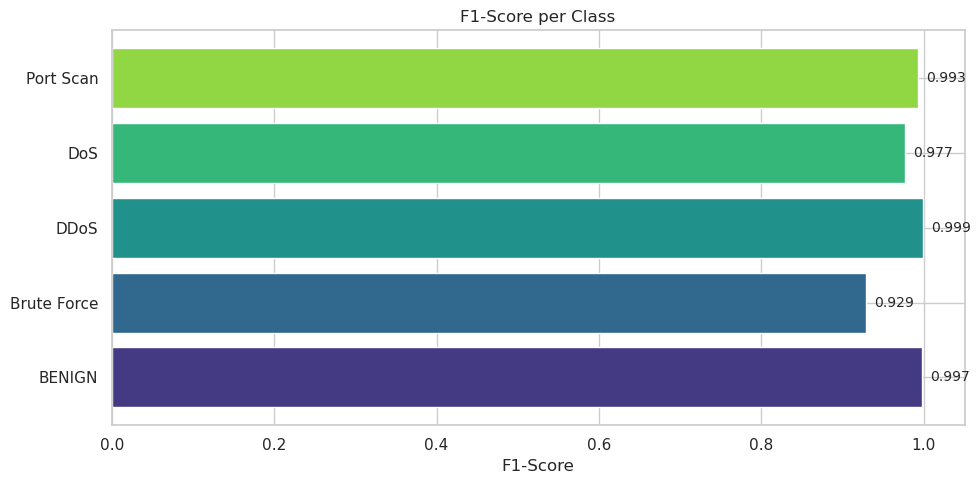

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.0)

def report_to_df(rep_dict, inv_label_map):
    rows = []
    for k, v in rep_dict.items():
        if k in ("accuracy", "macro avg", "weighted avg"):
            continue
        try:
            cls_idx = int(k)
            cls_name = inv_label_map. get(cls_idx, str(k))
        except:
            cls_name = k
        rows.append({
            "class_name": cls_name,
            "precision": v. get("precision", 0),
            "recall": v.get("recall", 0),
            "f1": v.get("f1-score", 0),
            "support": v.get("support", 0)
        })
    return pd.DataFrame(rows)

metrics_df = report_to_df(final_rep, inv_label_map)
print("Per-Class Metrics:")
display(metrics_df)

fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette("viridis", len(metrics_df))
bars = ax.barh(metrics_df['class_name'], metrics_df['f1'], color=colors)
ax. set_xlabel('F1-Score')
ax. set_title('F1-Score per Class')
ax. set_xlim(0, 1.05)

for bar, val in zip(bars, metrics_df['f1']):
    ax.text(bar. get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt. savefig(ART_DIR / 'f1_per_class.png', dpi=150, bbox_inches='tight')
plt.show()

clear_memory()

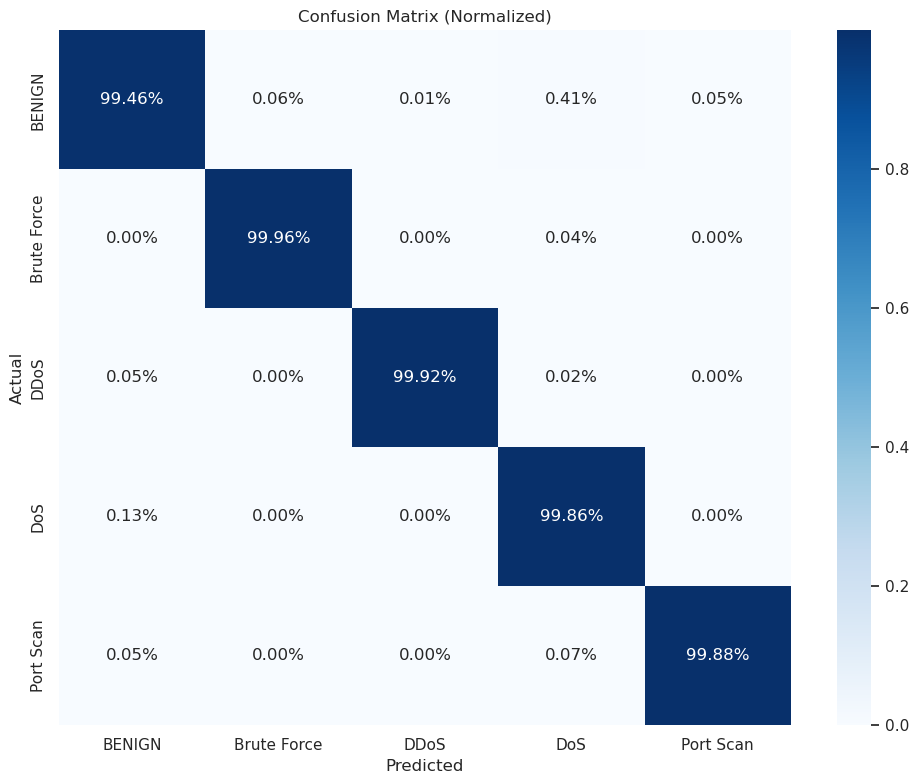


Confusion Matrix (Raw counts):


,BENIGN,Brute Force,DDoS,DoS,Port Scan
BENIGN,640560,414,61,2655,346
Brute Force,0,2744,0,1,0
DDoS,19,1,38375,9,0
DoS,77,2,1,58043,1
Port Scan,13,1,0,20,27174


In [22]:
cm = confusion_matrix(y_test_arr, y_pred)
cm_normalized = cm. astype('float') / cm. sum(axis=1)[:, np. newaxis]

fig, ax = plt. subplots(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=ax)
ax. set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix (Normalized)')
plt.tight_layout()
plt.savefig(ART_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion Matrix (Raw counts):")
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
display(cm_df)

del cm, cm_normalized
clear_memory()

## 6.  Simpan Artefak Model (SESUAI PROPOSAL)

In [25]:
print("=" * 60)
print("MENYIMPAN SEMUA ARTEFAK SESUAI PROPOSAL")
print("=" * 60)

# 1. model_state. pt - PyTorch state dict
torch.save(final_model.state_dict(), ART_DIR / 'model_state.pt')
print(f"✅ [1/6] model_state.pt saved")

# 2.  scaler.pkl - RobustScaler (terpisah)
joblib.dump(phaseB_meta['scaler'], ART_DIR / 'scaler.pkl')
print(f"✅ [2/6] scaler.pkl saved")

# 3. transform_meta.json - Kolom final, heavy cols, medians
transform_meta_json = {
    'cols': phaseB_meta['cols'],
    'heavy_cols': phaseB_meta['heavy_cols'],
    'medians': {k: float(v) for k, v in phaseB_meta['medians'].items()},
    'skew_threshold': SKEW_THRESHOLD,
    'use_robust_scaler': USE_ROBUST_SCALER
}
with open(ART_DIR / 'transform_meta.json', 'w') as f:
    json. dump(transform_meta_json, f, indent=2)
print(f"✅ [3/6] transform_meta. json saved")

# 4. config.json - Hyperparameter terbaik
config_json = {
    'split_ratio': float(final_config['split_ratio']),
    'layers': final_config['layers'],
    'activation': final_config['activation'],
    'learning_rate': float(final_config['learning_rate']),
    'epochs': int(final_config['epochs']),
    'batch_size': int(final_config['batch_size']),
    'dropout': float(final_config['dropout']),
    'num_classes': int(final_config['num_classes']),
    'input_dim': int(final_config['input_dim']),
    'optimizer': 'AdamW',
    'weight_decay': 1e-4,
    'early_stopping_patience': 12,
    'gradient_clip_norm': 5.0
}
with open(ART_DIR / 'config.json', 'w') as f:
    json. dump(config_json, f, indent=2)
print(f"✅ [4/6] config.json saved")

# 5. label_map.json - Mapping label ke numerik
label_map_json = {
    'label_to_id': {k: int(v) for k, v in label_map.items()},
    'id_to_label': {str(k): v for k, v in inv_label_map. items()}
}
with open(ART_DIR / 'label_map.json', 'w') as f:
    json. dump(label_map_json, f, indent=2)
print(f"✅ [5/6] label_map. json saved")

# 6. report. json - Hasil evaluasi (metrik)
report_json = {
    'macro_f1': float(mf1_final),
    'accuracy': float(final_rep['accuracy']),
    'weighted_f1': float(final_rep['weighted avg']['f1-score']),
    'weighted_precision': float(final_rep['weighted avg']['precision']),
    'weighted_recall': float(final_rep['weighted avg']['recall']),
    'per_class': {}
}
for k, v in final_rep.items():
    if k not in ('accuracy', 'macro avg', 'weighted avg'):
        try:
            cls_idx = int(k)
            cls_name = inv_label_map. get(cls_idx, str(k))
        except:
            cls_name = k
        report_json['per_class'][cls_name] = {
            'precision': float(v.get('precision', 0)),
            'recall': float(v.get('recall', 0)),
            'f1-score': float(v.get('f1-score', 0)),
            'support': int(v. get('support', 0))
        }

with open(ART_DIR / 'report.json', 'w') as f:
    json.dump(report_json, f, indent=2)
print(f"✅ [6/6] report. json saved")

print("\n" + "=" * 60)
print("SEMUA ARTEFAK BERHASIL DISIMPAN!")
print("=" * 60)

MENYIMPAN SEMUA ARTEFAK SESUAI PROPOSAL
✅ [1/6] model_state.pt saved
✅ [2/6] scaler.pkl saved
✅ [3/6] transform_meta. json saved
✅ [4/6] config.json saved
✅ [5/6] label_map. json saved
✅ [6/6] report. json saved

SEMUA ARTEFAK BERHASIL DISIMPAN!


In [27]:
print("\n" + "=" * 60)
print("VERIFIKASI ARTEFAK")
print("=" * 60)

expected_files = [
    ('model_state.pt', 'PyTorch state dict'),
    ('scaler.pkl', 'Pickle'),
    ('transform_meta.json', 'JSON'),
    ('config.json', 'JSON'),
    ('label_map.json', 'JSON'),
    ('report.json', 'JSON')
]

all_exist = True
for fname, fformat in expected_files:
    fpath = ART_DIR / fname
    if fpath.exists():
        size_kb = fpath.stat().st_size / 1024
        print(f"✅ {fname:<25} ({fformat:<20}) - {size_kb:.2f} KB")
    else:
        print(f"❌ {fname:<25} ({fformat:<20}) - TIDAK ADA! ")
        all_exist = False

if all_exist:
    print("\n🎉 Semua artefak tersimpan dengan benar!")
else:
    print("\n⚠️ Ada artefak yang hilang!")


VERIFIKASI ARTEFAK
✅ model_state.pt            (PyTorch state dict  ) - 749.17 KB
✅ scaler.pkl                (Pickle              ) - 1.27 KB
✅ transform_meta.json       (JSON                ) - 2.33 KB
✅ config.json               (JSON                ) - 0.32 KB
✅ label_map.json            (JSON                ) - 0.23 KB
✅ report.json               (JSON                ) - 0.99 KB

🎉 Semua artefak tersimpan dengan benar!


In [28]:
print("\n" + "=" * 60)
print("                    FINAL SUMMARY                          ")
print("=" * 60)
print(f"Dataset: CIC-IDS2017 (5 classes)")
print(f"Total samples: {len(full_df):,}")
print(f"Features: {len(phaseB_meta['cols'])}")
print(f"Classes: {list(label_map.keys())}")
print("\n--- Model Configuration ---")
print(f"Architecture: DNN {final_config['layers']}")
print(f"Activation: {final_config['activation']}")
print(f"Dropout: {final_config['dropout']}")
print(f"Learning Rate: {final_config['learning_rate']}")
print(f"Epochs: {final_config['epochs']}")
print(f"Batch Size: {final_config['batch_size']}")
print("\n--- Performance Metrics ---")
print(f"Macro F1-Score: {mf1_final:.4f}")
print(f"Accuracy: {final_rep['accuracy']:.4f}")
print(f"Weighted F1: {final_rep['weighted avg']['f1-score']:.4f}")
print("\n--- Per-Class F1 ---")
for idx, row in metrics_df.iterrows():
    print(f"  {row['class_name']}: {row['f1']:.4f}")
print("\n--- Saved Artifacts ---")
print(f"  📁 {ART_DIR. absolute()}")
for fname, _ in expected_files:
    print(f"     └── {fname}")
print("=" * 60)


                    FINAL SUMMARY                          
Dataset: CIC-IDS2017 (5 classes)
Total samples: 2,568,389
Features: 50
Classes: ['BENIGN', 'Brute Force', 'DDoS', 'DoS', 'Port Scan']

--- Model Configuration ---
Architecture: DNN [512, 256, 128]
Activation: leaky_relu
Dropout: 0.35
Learning Rate: 0.001
Epochs: 60
Batch Size: 32

--- Performance Metrics ---
Macro F1-Score: 0.9790
Accuracy: 0.9953
Weighted F1: 0.9954

--- Per-Class F1 ---
  BENIGN: 0.9972
  Brute Force: 0.9291
  DDoS: 0.9988
  DoS: 0.9767
  Port Scan: 0.9930

--- Saved Artifacts ---
  📁 /home/alfanahmuhson/artifacts_multiclass_collapsed_v4
     └── model_state.pt
     └── scaler.pkl
     └── transform_meta.json
     └── config.json
     └── label_map.json
     └── report.json
